# Purpose

This prototype extends the prototype 4 to a network of SNRs.

In [1]:
from prototype04_cbcsnrs import CBCSNRsBase, compute_bilby_snr
import numpy as np
import pylab as plt
import bilby

In [2]:
# Function for computing bilby SNRs
def compute_bilby_snr(mass_1, mass_2, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, luminosity_distance, theta_jn, psi, phase, geocent_time, ra, dec, duration=4.0, sampling_frequency=4096, waveform_arguments=  dict(waveform_approximant = "IMRPhenomXPHM", reference_frequency = 50., minimum_frequency = 40), list_of_detectors=["L1", "H1", "V1"]):
    # Set the duration and sampling frequency of the data segment that we're
    # going to inject the signal into
    # Specify the output directory and the name of the simulation.
    bilby.core.utils.logger.disabled = True
    # Set up a random seed for result reproducibility. 
    np.random.seed(88170235)
    # We are going to inject a binary black hole waveform.  We first establish a
    # dictionary of parameters that includes all of the different waveform
    # parameters, including masses of the two black holes (mass_1, mass_2),
    # spins of both black holes (a, tilt, phi), etc.
    injection_parameters = dict(
        mass_1=mass_1,
        mass_2=mass_2,
        a_1=a_1,
        a_2=a_2,
        tilt_1=tilt_1,
        tilt_2=tilt_2,
        phi_12=phi_12,
        phi_jl=phi_jl,
        luminosity_distance=luminosity_distance,
        theta_jn=theta_jn,
        psi=psi,
        phase=phase,
        geocent_time=geocent_time,
        ra=ra,
        dec=dec
    )
    # Create the waveform_generator using a LAL BinaryBlackHole source function
    # the generator will convert all the parameters
    waveform_generator = bilby.gw.WaveformGenerator(
        duration=duration,
        sampling_frequency=sampling_frequency,
        frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
        parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
        waveform_arguments=waveform_arguments,
    )
    # Set up interferometers.  In this case we'll use two interferometers
    # (LIGO-Hanford (H1), LIGO-Livingston (L1). These default to their design
    # sensitivity
    ifos = bilby.gw.detector.InterferometerList(list_of_detectors)
    ifos.set_strain_data_from_power_spectral_densities(
        sampling_frequency=sampling_frequency,
        duration=duration,
        start_time=injection_parameters["geocent_time"] - 2,
    )
    ifos.inject_signal(
        waveform_generator=waveform_generator, parameters=injection_parameters
    );
    network_optimal_snr_squared = 0
    for i in range(len(ifos)):
        single_detector_optimal_snr = ifos[i].meta_data['optimal_SNR']
        # Sum in quadrature
        network_optimal_snr_squared = network_optimal_snr_squared + single_detector_optimal_snr**2
    network_optimal_snr = np.sqrt(network_optimal_snr_squared)
    return network_optimal_snr

In [19]:
class BBHSNRInterpolator(CBCSNRsBase):
    def __init__(self, total_mass_min, total_mass_max, sampling_frequency=4096, waveform_arguments= dict(waveform_approximant = "IMRPhenomXPHM", reference_frequency = 50., minimum_frequency = 20), list_of_detectors=["L1", "H1", "V1"]):
        # Set masses to be the same for now:
        nsamples = 200
        total_mass = np.geomspace(total_mass_min,  total_mass_max, nsamples)
        mass_1 = total_mass/2 # Equal mass in preliminary computation
        mass_2 = total_mass/2 # Equal mass in preliminary computation
        # Compute the inner products for each mass
        super().__init__(mass_1, mass_2, sampling_frequency, waveform_arguments, list_of_detectors)
        # Save values
        self.total_mass_min = total_mass_min
        self.total_mass_max = total_mass_max
        self.total_mass_table = total_mass
    def interpolate_inner_products_idx(self, total_mass):
        # Zeroth order approximation: Just return the inner product that is nearest to the correct mass value
        idx = np.searchsorted(self.total_mass_table, total_mass)
        return idx
    def single_detector_optimal_snr(self, mass_1, mass_2, luminosity_distance, theta_jn, ra, dec, psi, phase, geocent_time, ifo='L1'):
        ''' Single-detector optimal snr
        '''
        total_mass = mass_1+mass_2
        mu = mass_1*mass_2/total_mass
        chirp_mass = mu**(3./5.)/total_mass**(2/5)
        chirp_mass_unscaled = total_mass**(1./5.)/(2.*2**(1./5.)) # Assuming q=1
        iota = theta_jn
        indices = self.interpolate_inner_products_idx(total_mass) # Get the indices for the inner products
        Fp, Fc = self.fast_ifo_objects[ifo].antenna_pattern(ra, dec, psi, geocent_time)
        hp_inner_hp, hc_inner_hc = self.hp_inner_hp[ifo][indices], self.hc_inner_hc[ifo][indices]
        Deff1 = luminosity_distance/np.sqrt(Fp**2*((1+np.cos(iota)**2)/2)**2+Fc**2*np.cos(iota)**2 )
        Deff2 = 100/np.sqrt(Fp**2*((1+np.cos(0)**2)/2)**2+Fc**2*np.cos(0)**2 )
        A1 = chirp_mass**(5./6.)
        A2 = chirp_mass_unscaled**(5./6.)
        optimal_snr_squared_unscaled = Fp**2*hp_inner_hp + Fc**2*hc_inner_hc
        # Rescale:
        return (Deff2/Deff1)*(A1/A2)*np.sqrt(np.real(optimal_snr_squared_unscaled))
    def evaluate(self, mass_1, mass_2, luminosity_distance, theta_jn, ra, dec, psi, phase, geocent_time):
        network_optimal_snr_squared = 0
        for ifo in self.list_of_detectors:
            single_detector_optimal_snr = self.single_detector_optimal_snr(mass_1, mass_2, luminosity_distance, theta_jn, ra, dec, psi, phase, geocent_time, ifo)
            # Add in quadrature
            network_optimal_snr_squared = network_optimal_snr_squared + single_detector_optimal_snr**2
        # Return the  network snr
        network_optimal_snr = np.sqrt(network_optimal_snr_squared)
        return network_optimal_snr
    def __call__(self, mass_1, mass_2, luminosity_distance, theta_jn, ra, dec, psi, phase, geocent_time):
        return self.evaluate(mass_1, mass_2, luminosity_distance, theta_jn, ra, dec, psi, phase, geocent_time)

In [21]:
q = 1 # Assume mass_1=mass_2
zmin, zmax = 0, 12
total_mass_min, total_mass_max = 5*(1+zmin), 100*2*(1+zmax) # Note: Redshifted masses
bbh_snr_interpolator = BBHSNRInterpolator(total_mass_min, total_mass_max)

In [22]:
mass_1 = 12
mass_2 = mass_1
luminosity_distance = 3604
theta_jn = np.pi/10
ra, dec, psi, phase, geocent_time = np.pi/5, np.pi/8, np.pi/3, 3*np.pi/5, 182381.12
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0
optimal_snrs = bbh_snr_interpolator(mass_1, mass_2, luminosity_distance, theta_jn, ra, dec, psi, phase, geocent_time)
optimal_snrs

6.510540431700085

In [23]:
compute_bilby_snr(mass_1, mass_2, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, luminosity_distance, theta_jn, psi, phase, geocent_time, ra, dec, duration=2*4, sampling_frequency=4096, waveform_arguments= dict(waveform_approximant = "IMRPhenomXPHM", reference_frequency = 50., minimum_frequency = 20), list_of_detectors=["L1", "H1", "V1"])

6.484074015446997

In [25]:
total_mass_max

2600

## Test  1

Now how well this works over a wide range of values

In [30]:
bilby_snrs = []
bilby_snrs2 = []
interpolated_snrs = []
nsamples = 40
masses = np.linspace(10,200,nsamples)
for i in range(nsamples):
    np.random.seed(i)
    mass_1 = masses[i]
    mass_2 = mass_1
    # Fix luminosity distance
    luminosity_distance = 800
    # Randomly sample everything else:
    theta_jn = np.random.uniform(0,2*np.pi)
    ra, dec, psi, phase, geocent_time = np.random.uniform(0,2*np.pi), np.random.uniform(0,np.pi), np.random.uniform(0,2*np.pi), np.random.uniform(0,2*np.pi), np.random.uniform(12933,1529132)
    a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin
    # Compute bilby snr first (verified/reviewed)
    bilby_snr = compute_bilby_snr(mass_1, mass_2, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, luminosity_distance, theta_jn, psi, phase, geocent_time, ra, dec, duration=2*4, sampling_frequency=4096, waveform_arguments= dict(waveform_approximant = "IMRPhenomXPHM", reference_frequency = 50., minimum_frequency = 20), list_of_detectors=["L1", "H1", "V1"])
    bilby_snrs.append(bilby_snr)
    # Compute the interpolated snr
    interpolated_snr = bbh_snr_interpolator(mass_1, mass_2, luminosity_distance, theta_jn, ra, dec, psi, phase, geocent_time)
    interpolated_snrs.append(interpolated_snr)

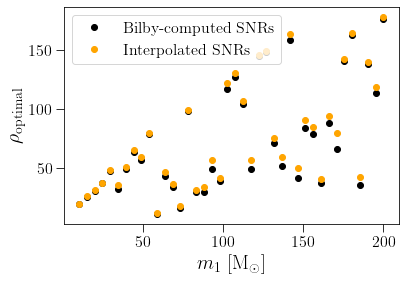

In [31]:
bilby_snrs = np.array(bilby_snrs)
interpolated_snrs = np.array(interpolated_snrs)
plt.plot(masses, bilby_snrs, 'o', color='black', label='Bilby-computed SNRs')
plt.plot(masses, interpolated_snrs, 'o', color='orange', label='Interpolated SNRs')
plt.xlabel(r"$m_1$ [$\rm M_\odot$]")
plt.ylabel(r"$\rho_{\rm optimal}$")
plt.legend()
plt.show()

# Test 2

* Does the SNR computation still hold for unequal mass binaries?
* Assume TaylorF2 waveform

In [48]:
bbh_snr_interpolator = BBHSNRInterpolator(total_mass_min, total_mass_max, sampling_frequency=4096, waveform_arguments= dict(waveform_approximant = "TaylorF2", reference_frequency = 50., minimum_frequency = 20), list_of_detectors=["L1", "H1", "V1"])

In [49]:
# STEP 1 compute the SNRs
nsamples = 20
masses = np.linspace(10,200,nsamples)
np.random.seed(0)
mass_1 = masses
q = np.random.uniform(0.2,1,size=nsamples)
mass_2 = mass_1*q
total_mass = mass_1+mass_2
# Fix luminosity distance
luminosity_distance = 80
# Randomly sample everything else:
theta_jn = np.random.uniform(0,2*np.pi, size=nsamples)
ra, dec, psi, phase, geocent_time = np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(12933,1529132, size=nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin
interpolated_snrs = bbh_snr_interpolator(mass_1, mass_2, luminosity_distance, theta_jn, ra, dec, psi, phase, geocent_time)

In [50]:
bilby_snrs = []
for i in range(nsamples):
    # Compute bilby snr first (verified/reviewed)
    bilby_snr = compute_bilby_snr(mass_1[i], mass_2[i], a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, luminosity_distance, theta_jn[i], psi[i], phase[i], geocent_time[i], ra[i], dec[i], duration=128*4, sampling_frequency=4096, waveform_arguments= dict(waveform_approximant = "TaylorF2", reference_frequency = 50., minimum_frequency = 20), list_of_detectors=["L1", "H1", "V1"])
    bilby_snrs.append(bilby_snr)
bilby_snrs = np.array(bilby_snrs)

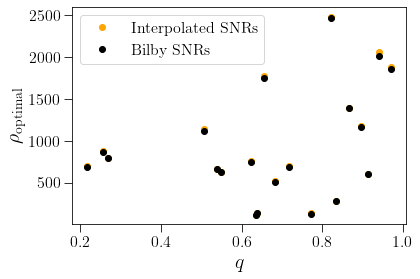

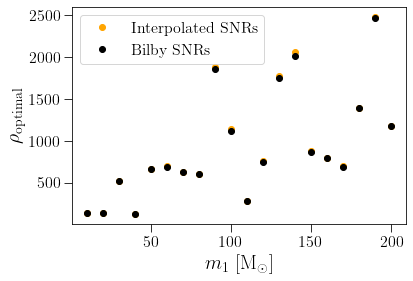

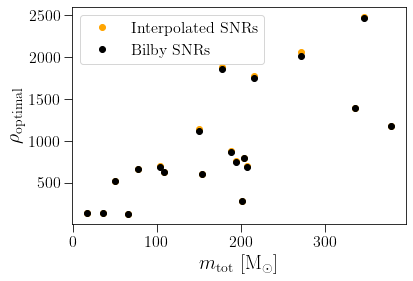

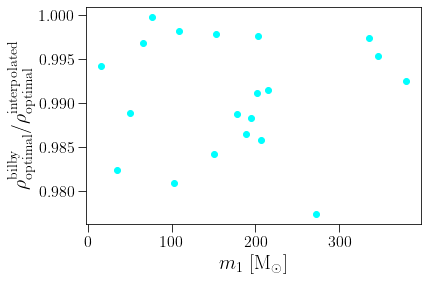

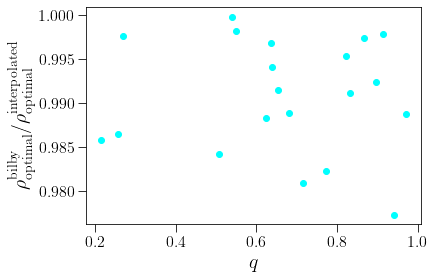

In [51]:
# Compare the SNRs
# STEP 3: Compare the SNRs
plt.plot(q, interpolated_snrs, 'o', color='orange', label='Interpolated SNRs')
plt.plot(q, bilby_snrs, 'o', color='black', label='Bilby SNRs')
plt.xlabel(r"$q$")
plt.ylabel(r"$\rho_{\rm optimal}$")
plt.legend()
plt.show()
plt.plot(mass_1, interpolated_snrs, 'o', color='orange', label='Interpolated SNRs')
plt.plot(mass_1, bilby_snrs, 'o', color='black', label='Bilby SNRs')
plt.xlabel(r"$m_1$ [$\rm M_\odot$]")
plt.ylabel(r"$\rho_{\rm optimal}$")
plt.legend()
plt.show()
plt.plot(total_mass, interpolated_snrs, 'o', color='orange', label='Interpolated SNRs')
plt.plot(total_mass, bilby_snrs, 'o', color='black', label='Bilby SNRs')
plt.xlabel(r"$m_{\rm tot}$ [$\rm M_\odot$]")
plt.ylabel(r"$\rho_{\rm optimal}$")
plt.legend()
plt.show()
# Plot the relative difference
plt.plot(total_mass, bilby_snrs/interpolated_snrs, 'o', color='cyan')
plt.xlabel(r"$m_1$ [$\rm M_\odot$]")
plt.ylabel(r"$\rho_{\rm optimal}^{\rm bilby}/\rho_{\rm optimal}^{\rm interpolated}$")
plt.show()
plt.plot(q, bilby_snrs/interpolated_snrs, 'o', color='cyan')
plt.xlabel(r"$q$")
plt.ylabel(r"$\rho_{\rm optimal}^{\rm bilby}/\rho_{\rm optimal}^{\rm interpolated}$")
plt.show()

**Conclusion:** The code does works reasonably well, with around 2% error.

# Test 3

* Does the interpolator work with the IMRPhenomD waveform?
* Repeat the earlier test, but with IMRPhenomD waveform 

In [72]:
bbh_snr_interpolator = BBHSNRInterpolator(5, 1000, sampling_frequency=4096, waveform_arguments= dict(waveform_approximant = "IMRPhenomD", reference_frequency = 50., minimum_frequency = 20), list_of_detectors=["L1", "H1", "V1"])

In [73]:
# STEP 1 compute the SNRs
nsamples = 20
masses = np.linspace(10,200,nsamples)
np.random.seed(0)
mass_1 = masses
q = np.random.uniform(0.2,1,size=nsamples)
mass_2 = mass_1*q
total_mass = mass_1+mass_2
# Fix luminosity distance
luminosity_distance = 80
# Randomly sample everything else:
theta_jn = np.random.uniform(0,2*np.pi, size=nsamples)
ra, dec, psi, phase, geocent_time = np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(12933,1529132, size=nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin
interpolated_snrs = bbh_snr_interpolator(mass_1, mass_2, luminosity_distance, theta_jn, ra, dec, psi, phase, geocent_time)

In [74]:
bilby_snrs = []
for i in range(nsamples):
    # Compute bilby snr first (verified/reviewed)
    bilby_snr = compute_bilby_snr(mass_1[i], mass_2[i], a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, luminosity_distance, theta_jn[i], psi[i], phase[i], geocent_time[i], ra[i], dec[i], duration=128*4, sampling_frequency=4096, waveform_arguments= dict(waveform_approximant = "IMRPhenomD", reference_frequency = 50., minimum_frequency = 20), list_of_detectors=["L1", "H1", "V1"])
    bilby_snrs.append(bilby_snr)
bilby_snrs = np.array(bilby_snrs)

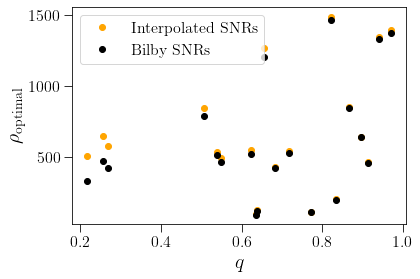

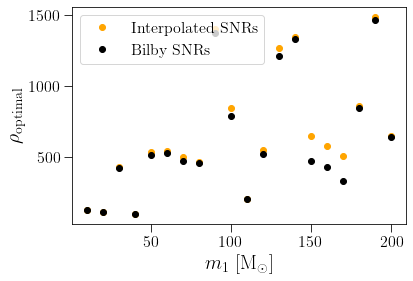

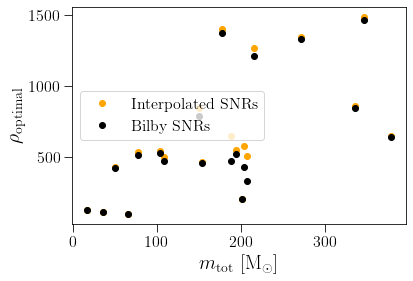

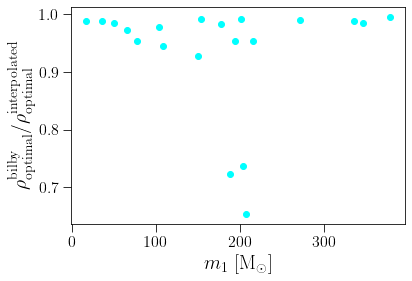

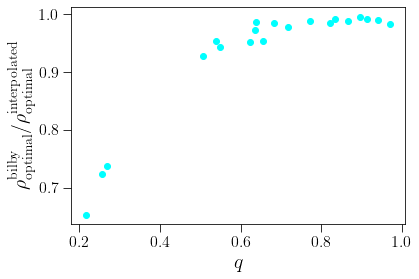

In [75]:
# Compare the SNRs
# STEP 3: Compare the SNRs
plt.plot(q, interpolated_snrs, 'o', color='orange', label='Interpolated SNRs')
plt.plot(q, bilby_snrs, 'o', color='black', label='Bilby SNRs')
plt.xlabel(r"$q$")
plt.ylabel(r"$\rho_{\rm optimal}$")
plt.legend()
plt.show()
plt.plot(mass_1, interpolated_snrs, 'o', color='orange', label='Interpolated SNRs')
plt.plot(mass_1, bilby_snrs, 'o', color='black', label='Bilby SNRs')
plt.xlabel(r"$m_1$ [$\rm M_\odot$]")
plt.ylabel(r"$\rho_{\rm optimal}$")
plt.legend()
plt.show()
plt.plot(total_mass, interpolated_snrs, 'o', color='orange', label='Interpolated SNRs')
plt.plot(total_mass, bilby_snrs, 'o', color='black', label='Bilby SNRs')
plt.xlabel(r"$m_{\rm tot}$ [$\rm M_\odot$]")
plt.ylabel(r"$\rho_{\rm optimal}$")
plt.legend()
plt.show()
# Plot the relative difference
plt.plot(total_mass, bilby_snrs/interpolated_snrs, 'o', color='cyan')
plt.xlabel(r"$m_1$ [$\rm M_\odot$]")
plt.ylabel(r"$\rho_{\rm optimal}^{\rm bilby}/\rho_{\rm optimal}^{\rm interpolated}$")
plt.show()
plt.plot(q, bilby_snrs/interpolated_snrs, 'o', color='cyan')
plt.xlabel(r"$q$")
plt.ylabel(r"$\rho_{\rm optimal}^{\rm bilby}/\rho_{\rm optimal}^{\rm interpolated}$")
plt.show()

# Test 4

* Does the interpolator work with the IMRPhenomXPHM waveform?
* Repeat the earlier test, but with IMRPhenomXPHM waveform 

In [56]:
bbh_snr_interpolator = BBHSNRInterpolator(total_mass_min, total_mass_max, sampling_frequency=4096, waveform_arguments= dict(waveform_approximant = "IMRPhenomXPHM", reference_frequency = 50., minimum_frequency = 20), list_of_detectors=["L1", "H1", "V1"])

In [57]:
# STEP 1 compute the SNRs
nsamples = 20
masses = np.linspace(10,200,nsamples)
np.random.seed(0)
mass_1 = masses
q = np.random.uniform(0.2,1,size=nsamples)
mass_2 = mass_1*q
total_mass = mass_1+mass_2
# Fix luminosity distance
luminosity_distance = 80
# Randomly sample everything else:
theta_jn = np.random.uniform(0,2*np.pi, size=nsamples)
ra, dec, psi, phase, geocent_time = np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(12933,1529132, size=nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin
interpolated_snrs = bbh_snr_interpolator(mass_1, mass_2, luminosity_distance, theta_jn, ra, dec, psi, phase, geocent_time)

In [58]:
bilby_snrs = []
for i in range(nsamples):
    # Compute bilby snr first (verified/reviewed)
    bilby_snr = compute_bilby_snr(mass_1[i], mass_2[i], a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, luminosity_distance, theta_jn[i], psi[i], phase[i], geocent_time[i], ra[i], dec[i], duration=128*4, sampling_frequency=4096, waveform_arguments= dict(waveform_approximant = "IMRPhenomXPHM", reference_frequency = 50., minimum_frequency = 20), list_of_detectors=["L1", "H1", "V1"])
    bilby_snrs.append(bilby_snr)
bilby_snrs = np.array(bilby_snrs)

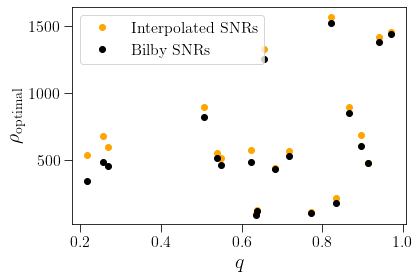

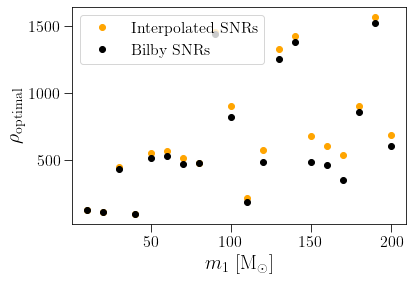

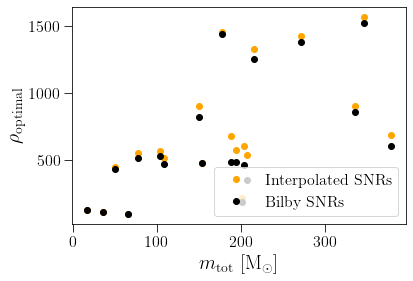

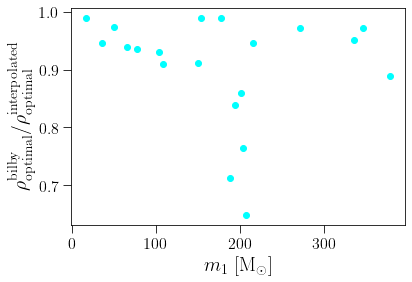

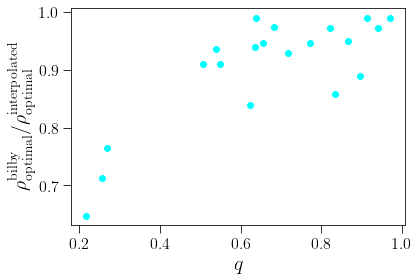

In [59]:
# Compare the SNRs
# STEP 3: Compare the SNRs
plt.plot(q, interpolated_snrs, 'o', color='orange', label='Interpolated SNRs')
plt.plot(q, bilby_snrs, 'o', color='black', label='Bilby SNRs')
plt.xlabel(r"$q$")
plt.ylabel(r"$\rho_{\rm optimal}$")
plt.legend()
plt.show()
plt.plot(mass_1, interpolated_snrs, 'o', color='orange', label='Interpolated SNRs')
plt.plot(mass_1, bilby_snrs, 'o', color='black', label='Bilby SNRs')
plt.xlabel(r"$m_1$ [$\rm M_\odot$]")
plt.ylabel(r"$\rho_{\rm optimal}$")
plt.legend()
plt.show()
plt.plot(total_mass, interpolated_snrs, 'o', color='orange', label='Interpolated SNRs')
plt.plot(total_mass, bilby_snrs, 'o', color='black', label='Bilby SNRs')
plt.xlabel(r"$m_{\rm tot}$ [$\rm M_\odot$]")
plt.ylabel(r"$\rho_{\rm optimal}$")
plt.legend()
plt.show()
# Plot the relative difference
plt.plot(total_mass, bilby_snrs/interpolated_snrs, 'o', color='cyan')
plt.xlabel(r"$m_1$ [$\rm M_\odot$]")
plt.ylabel(r"$\rho_{\rm optimal}^{\rm bilby}/\rho_{\rm optimal}^{\rm interpolated}$")
plt.show()
plt.plot(q, bilby_snrs/interpolated_snrs, 'o', color='cyan')
plt.xlabel(r"$q$")
plt.ylabel(r"$\rho_{\rm optimal}^{\rm bilby}/\rho_{\rm optimal}^{\rm interpolated}$")
plt.show()

# Conclusion

* The code works also with BBH waveforms
* HOWEVER, the code does -not- work for low mass ratio and IMRPhenomXPHM or IMRPhenomD waveforms (over-estimates the SNR)